<a href="https://colab.research.google.com/github/ssnirgudkar/Datasetpaper-final/blob/main/deeplab2_Finalpaper_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Use this version as the most final


to do - 
1. visaulaization is per image. We need to add code to save the output to a file
2. need to train the model on 100 epochs
3. add training - restart code - so pick up the model and retrain 

## we have to keep batchsize = 2 or more. It does not run with batch size 1. Image will be resized to 512*512
##changed mask datatype to uint16 from uint8. segments.ai masks are uint16. else it reads masks as 0
##the resize was changed to nearest. but we can check if thats needed. bilinear is default. So we can try to keep it as bilinera and that shld also work. With this run, objects were not coming up well. objects and background was getting mixed

Run2 11/11 - Uncommented the 127.5-1 code. so now both image and masks are float 32. also changed the nearest back to bilnear. changed the batch size from 10 to 4. running with 50 epochs to see how it works.

Train images - 
Val images - 
Test images 
Epochs - 500 
Train time -

##Run3 - 
Train images - 3438
Val images - 982
Test images - 492
Epochs - 50 
Train time - 3 hrs 49 min
Test time - 
Any preloaded weights - NO. Imagenet weights are not used
The masks are uint8. the code had it as uint16. Hence we were getting pixel values of 257. fixed that
Model - deeplab-finalpapersubmission_V1

##Run4 - 
Train images - 26081
Val images - 7452
Test images - 3726
Epochs - 25(will break into 4 parts as this is a big dataset.  
Train time - 10 hrs 40 min
Test time - 
Any preloaded weights - NO. Imagenet weights are not used
Model - deeplab-finalpapersubmission (the next ones will be submission2,3 and 4)
infernce folder - IRDatasetFinal-Inferences
loss: 0.0623 - accuracy: 0.9790 

##Run5 - 2020 & 2021
loss: 0.0361 - accuracy: 0.9873 - val_loss: 3.3841 - val_accuracy: 0.7209
epochs - 50 
ran with 2020 and 2021 dataset only 
Model - deeplab folder - deeplab-finalpapersubmission-2020only (there's another with 2020-only. need to check)
training time - 9 hrs, 27 min

# https://keras.io/examples/vision/deeplabv3_plus/

In [1]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetConsolidated/train.zip", "r")
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/train.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/trainannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/val.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/valannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()
'''
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/test.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/testannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()
'''

'\nzip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/test.zip", "r")\nzip_ref.extractall("/content/IRDatasetFinal")\nzip_ref.close()\n\nzip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/testannot.zip", "r")\nzip_ref.extractall("/content/IRDatasetFinal")\nzip_ref.close()\n'

In [3]:
import os 
APP_FOLDER = '/content/IRDatasetFinal/train'
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
   

print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  /content/IRDatasetFinal/train
Total number of files 10562
Total Number of directories 0
Total: 10562


In [4]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Downloading the data We will use the Crowd Instance-level Human Parsing Dataset for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images. Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification. This dataset can be used for the "human part segmentation" task.

In [ ]:
#!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
#!unzip -q instance-level-human-parsing.zip

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
# to copy files from google drive to colab memory
#%cp -av /content/drive/MyDrive/TheIRDatasetMini/ TheIRDatasetMini
'''

Mounted at /content/drive


In [5]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 7
#DATA_DIR = '/content/drive/MyDrive/TheIRDatasetMini_backup'
DATA_DIR = '/content/IRDatasetFinal'
#DATA_DIR = '/content/drive/MyDrive/TheIRDataset'
#DATA_DIR = '/content/drive/MyDrive/IR -test'

#VAL_DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
#NUM_TRAIN_IMAGES = 80
#NUM_VAL_IMAGES = 10

'''
train_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "trainannot/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "trainannot/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
'''
train_images = sorted(glob(os.path.join(DATA_DIR, "train/*"))) 
train_masks = sorted(glob(os.path.join(DATA_DIR, "trainannot/*"))) 

val_images = sorted(glob(os.path.join(DATA_DIR, "val/*")))
val_masks = sorted(glob(os.path.join(DATA_DIR, "valannot/*")))

#test_images = sorted(glob(os.path.join(DATA_DIR, "test/*")))
#test_masks = sorted(glob(os.path.join(DATA_DIR, "testannot/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    print("image=", image)
    if mask:
        image = tf.image.decode_png(image, channels=0, dtype=tf.uint8)
        #print("mask 1st read", image)
        #print("Max value of mask as per tef.reduce are", tf.reduce_max(image))
        image.set_shape([None, None, 1])
        #print("mask 2nd read", image)
        image = tf.image.resize(images=image, method= 'bilinear', size=[IMAGE_SIZE, IMAGE_SIZE])
        #print("mask 3rd read after resize", image)
        #print('final image' ,image)
        #print('unique values of tensor' , tf.unique(image))
    else:
        image = tf.image.decode_png(image, channels=3, dtype=tf.uint8)
        #print("1st step in read image", image)
        image.set_shape([None, None, 3])
        #print("2nd step in read image", image)
        image = tf.image.resize(images=image, method= 'bilinear', size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
        #print("image looks like", image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

read_image(train_masks[20], mask=True)

#print ((np.unique(cv2.imread(train_masks[1],cv2.IMREAD_UNCHANGED))))


#print("Train Dataset:", train_dataset)
#print("Val Dataset:", val_dataset)

image= Tensor("ReadFile:0", shape=(), dtype=string)
image= Tensor("ReadFile_1:0", shape=(), dtype=string)
image= Tensor("ReadFile:0", shape=(), dtype=string)
image= Tensor("ReadFile_1:0", shape=(), dtype=string)
image= tf.Tensor(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x02\x00\x08\x00\x00\x00\x007\x16\x82\'\x00\x00\x10}IDATx\x9c\xed\xdd\xdb\x9a\xe28\x12E\xe1`H\xe6\xfd\x9f\xb7H>\xfa\x82Cb\xe3\x83$K\xda!i\xfd\x17\xd3U\xd3Y4\r\xabC\xb61\xf6\xe9\xff\xe6\xd9\xfd\xf37\xd7c\x8fu\xd9\xf9\xfb\x07\x1f\x1eI~\xd4O`\xc3}\xffG\xd0:\xbf\x01~\xe5WzB]\x98\x81\x02\xffS?\x01\x8c\xcdk\x80\xf7\xef\xf5wo\x1b\x0e-\xf2\xb9\x04/n\xfd\xb1@\xf6\xc8a\x80\xff\xca\x0c;\x06\xa8K\xee\x02\xfcg\xb42\x12_\x01\xfeS?\x01\xd4\xe6)\xc0\xed\xfc\n\x1f\x86f\x1bS\xc3M\x80\x0c\xbf1y=\x0c\x83A8\x99\x80\x93\xf9\xc7>\xc8@<\x04\x18\xb4\xfa\xb2\x85\xd6\'}\x80U6\xfe\x02\x86*\x85K\x88\x03\\\xaa\x8f\x15x$\xda\x9d\x90\xf0\xe9\xc7|\xea\x94r\x02\xd6;\xf2\xc2\n\xec\x96,\xc0\xd5\xfaX\x81\x87\xa2\t0z\xf61\x9fz\xa5\x08\xb0

<tf.Tensor: shape=(512, 512, 1), dtype=float32, numpy=
array([[[6.],
        [6.],
        [6.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[6.],
        [6.],
        [6.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[6.],
        [6.],
        [6.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [6.],
        [6.],
        [6.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [6.],
        [6.],
        [6.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [6.],
        [6.],
        [6.]]], dtype=float32)>

In [ ]:
#print(train_masks)
print(train_images)
print(train_masks)

In [6]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        #weights="imagenet", include_top=False, input_tensor=model_input - removed imagenet weights
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

In [ ]:
#### This is the training cell
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

my_callbacks = [
    #tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Logs/Unet-7classes-finalpapersubmission'),
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only", save_freq = 'epoch', save_best_only=True)

]
history = model.fit(train_dataset, validation_data=val_dataset, callbacks = my_callbacks, epochs=50)
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
#plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
#plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
#plt.show()

model.save("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only")

model loaded
Epoch 1/50
2640/2640 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9876INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2640/2640 [==============================] - 650s 241ms/step - loss: 0.0352 - accuracy: 0.9876 - val_loss: 6.3255 - val_accuracy: 0.6460
Epoch 2/50
2640/2640 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9875INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2640/2640 [==============================] - 632s 239ms/step - loss: 0.0354 - accuracy: 0.9875 - val_loss: 4.0017 - val_accuracy: 0.7097
Epoch 3/50
2640/2640 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.9877INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2640/2640 [==============================] - 674s 255ms/step - loss: 0.0348 - accuracy: 0.9877 - val_loss: 3.9654 - val_accuracy: 0.7082
Epoch 4/50
2640/2640 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9880INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2640/2640 [==============================] - 673s 255ms/step - loss: 0.0336 - accuracy: 0.9880 - val_loss: 3.9180 - val_accuracy: 0.7189
Epoch 5/50
2640/2640 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9881INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2640/2640 [==============================] - 673s 255ms/step - loss: 0.0335 - accuracy: 0.9881 - val_loss: 3.6865 - val_accuracy: 0.7271
Epoch 6/50
2640/2640 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9882INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2640/2640 [==============================] - 633s 240ms/step - loss: 0.0331 - accuracy: 0.9882 - val_loss: 3.5524 - val_accuracy: 0.7700
Epoch 7/50
2640/2640 [==============================] - 610s 231ms/step - loss: 0.0326 - accuracy: 0.9884 - val_loss: 4.1682 - val_accuracy: 0.7160
Epoch 8/50
2640/2640 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9883INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2640/2640 [==============================] - 632s 240ms/step - loss: 0.0329 - accuracy: 0.9883 - val_loss: 1.3718 - val_accuracy: 0.7722
Epoch 9/50
2640/2640 [==============================] - 609s 231ms/step - loss: 0.0327 - accuracy: 0.9883 - val_loss: 3.1462 - val_accuracy: 0.7160
Epoch 10/50
2640/2640 [==============================] - 609s 231ms/step - loss: 0.0318 - accuracy: 0.9886 - val_loss: 4.1970 - val_accuracy: 0.6570
Epoch 11/50
2640/2640 [==============================] - 612s 232ms/step - loss: 0.0316 - accuracy: 0.9887 - val_loss: 4.9928 - val_accuracy: 0.6726
Epoch 12/50
2640/2640 [==============================] - 651s 247ms/step - loss: 0.0307 - accuracy: 0.9889 - val_loss: 3.2418 - val_accuracy: 0.7083
Epoch 13/50
2640/2640 [==============================] - 610s 231ms/step - loss: 0.0311 - accuracy: 0.9888 - val_loss: 2.9630 - val_accuracy: 0.7222
Epoch 14/50
2640/2640 [==============================] - 651s 246ms/step - loss: 0.0313 - accuracy: 0.9888 - val_loss: 

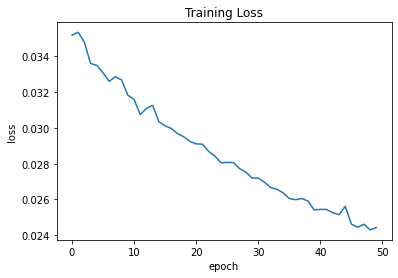

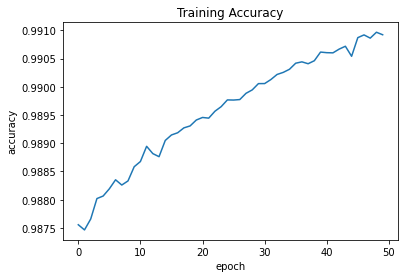

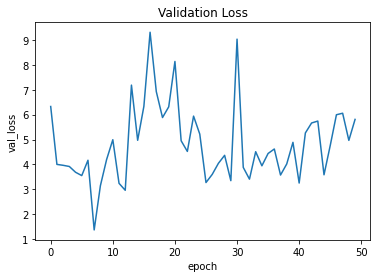

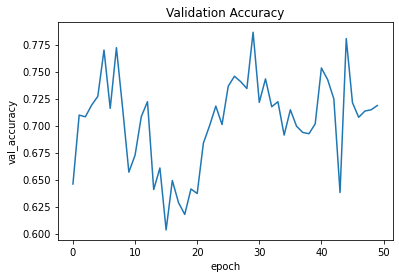

In [8]:
## this is to retrain the saved model - RUN#2
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only")
print("model loaded")

my_callbacks = [
    #tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Logs/Unet-7classes-finalpapersubmission'),
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only", save_freq = 'epoch', save_best_only=True)

               ]

history = reconstructed_model.fit(train_dataset, validation_data=val_dataset, callbacks = my_callbacks, epochs=50)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

#commented below as checkpoint already has save best. else it will create a duplicate
#print("model to be saved")
#reconstructed_model.save("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only")
#print("model saved")

In [ ]:
## Inference 
## this is to use the saved model for predictions
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Models/deeplab-finalpapersubmission")

In [ ]:
import PIL

# Loading the Colormap. Defaulting since i have changed the colors hardcoded in the code
'''
colormap = loadmat(
   "/content/drive/MyDrive/deeplab/human_colormap.mat")["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)
print("shape of colormap", np.shape(colormap)) - (20,3)
print("type of colormap", type(colormap)) - ndarray 
'''

colormap = np.ndarray(shape=(7,3), dtype=int);
#colormap = np.zeros(7,3) 
#0 - sky - dark blue
colormap[0,0]=0
colormap[0,1]=113
colormap[0,2]=188

#1 - water - orange
colormap[1,0]= 216
colormap[1,1]= 82
colormap[1,2]= 24

#2 - bridge - yellow
colormap[2,0]= 236
colormap[2,1]= 176
colormap[2,2]= 31

#3 - obstacle - purple
colormap[3,0]= 125
colormap[3,1]= 46
colormap[3,2]= 141

#4 - living obstacle - green
colormap[4,0]= 118
colormap[4,1]= 171
colormap[4,2]= 47

#5 - backgnd - brown
colormap[5,0]= 161
colormap[5,1]= 19
colormap[5,2]= 46

#6 - self - red
colormap[6,0]= 255
colormap[6,1]= 0
colormap[6,2]= 0

def infer(model, image_tensor):
    #print("image tensor looks like", image_tensor)
    predictions = reconstructed_model.predict(np.expand_dims((image_tensor), axis=0))
    #print("predictions 1st step", predictions)
    predictions = np.squeeze(predictions)
    #print("predictions 2nd step after squeeze", predictions)
    predictions = np.argmax(predictions, axis=2)
    #print("predictions 3rd step after argmax", predictions)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    #print(rgb)
    return rgb

'''
def visualize2(predicted_mask):
    """Quick utility to display a model's prediction. we need color masked images, so displaying both color and black and white"""
    #label_colours = [(59,193,246), (222,168,51), (161,78,69), (177, 168, 52), (238, 159, 231), (240, 244, 74), (160, 253, 134)]  
    #label_colours = [(246,193,59), (51,168,222), (69,78,161), (52, 168, 177), (231, 159, 238), (74, 244, 240), (134, 253, 160)]  
                    
    #0 - sky(dark.blue). 
    #1 - water(light.blue).   
    #2 - bridge(yellow).   
    #3 - obstacle(purple).  
    #4- living ob(green).  
    #5- backgnd (orange). 
    #6 - self(pink)
    # Colors are same as segments.ai scheme
    label_colours = [(0,113,188), (216,82,24), (236,176,31), (125, 46, 141), (118, 171, 47), (161, 19, 46), (255,0,0)]  
    
    print("mask shape = ", np.shape(predicted_mask))
    print("Unique pixel values = ", np.unique(predicted_mask))
    print("Type of mask = ", type(predicted_mask))
    

    img1 = PIL.Image.new('RGB', (320, 256))
    pixels = img1.load()
    print(type(pixels))
    print(pixels[0,0])
    for j_, j in enumerate(predicted_mask[:, :]):
        #print (j_, j)
        for k_, k in enumerate(j):
              #print(k_, k)
              if k < num_classes:
                  pixels[k_,j_] = label_colours[k]
    output = np.array(img1)
    
    print("this is the colored inferred image")
    display(img1)
'''

def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


#def plot_samples_matplotlib(display_list, figsize=(5, 3)):
def plot_samples_matplotlib(display_list, filename, index, start, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])

    index_mod = index+start 
    #Saving the inferred segmented image as a picture 
    plt.savefig('/content/drive/MyDrive/IRdatasetmini-inferences/deeplab/picture/' + str(index_mod) +'--run1--' +  filename)
    
    #Displays the image on screen         
    #print (index)
    plt.show()
    


def plot_predictions(images_list, masks_list, start, colormap, model):
    for (index, mask_file) in enumerate(masks_list):
      gt_mask_array = ((np.unique(cv2.imread(mask_file,cv2.IMREAD_UNCHANGED))))
      #print ("mask file is", mask_file)
      filename = mask_file.split('/')[-1]
      #print(filename)
      object_living_array = [3,4]
      if((set(object_living_array) & set(gt_mask_array))== set(object_living_array)):
            image_tensor = read_image(images_list[index])
            prediction_mask = infer(image_tensor=image_tensor, model=reconstructed_model)
            #print(prediction_mask)

            output_Im = PIL.Image.fromarray(prediction_mask.astype(np.uint8))

            index_mod = index+start 

            ##Saving the category ids in an image for programatic IoU check 
            output_Im.save(('/content/drive/MyDrive/IRdatasetmini-inferences/deeplab/program/' + str(index_mod) +'--run1--' +  filename))

            prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 7)
            overlay = get_overlay(image_tensor, prediction_colormap)
            '''
            plot_samples_matplotlib(
              [image_tensor, overlay, prediction_colormap], figsize=(18, 14) 
                                  )
            '''
            plot_samples_matplotlib(
              [image_tensor, overlay, prediction_colormap], filename, index, start, figsize=(18, 14) 
                                  )

In [ ]:
start = 50
end = 100
plot_predictions(test_images[start:end], test_masks [start:end], start, colormap, model=reconstructed_model)

In [ ]:
plot_predictions(test_masks[300:301], colormap, model=reconstructed_model)